# Modeling Our Data Using Classification Methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models
from sklearn import linear_model # logistic regression
from sklearn.linear_model import LogisticRegression

# hyper-parameter tuning and cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Modeling Our Data
1. Define the predictors and outcome
    - Decided to include all questions answered rather than an average over the questions for each scale. I would only want to use an average for the scales if I think that the coefficient for all the questions would be the same. It's possible that while the questions in these scales were designed to represent the same trait/behavior that some questions are more revealing of which group someone is in. if this is the case, then we would want to use all the individual questions as features rather than the averages. I'm just going to go ahead and include each individual question.
2. Perform any preprocessing necessary:
    - Convert features and outcome to numerical (0's and 1's)
3. Split into training and test sets
    - used a 70/30 split since our dataset is small
    - scaled the predictors after because that is often necessary for logistic regression
4. Define the classifiers I want to use
    - Decided on logistic regression because I am interested in including an interaction as a predictor in the model. Whil eother models can implicitly capture interactions, I want to compare a model without an interaction term to a model with an interction term. 
5. Perform hyper-parameter tuning using cross-validation on the training data to decide on the best model
    - Potentially penalize for number of predictors since our dataset is so small. Explain the penalty used.
    - Used accuracy to perform hyper-parameter tuning. Since the classes are fairly balanced and I'm not differentially concerned about false positives or false negatives, accuracy is a good metric to evaluate these models with. I want to see if it's possible for these models to produce accurate predictions of which condition someone was in, and it's ok if the model is slightly better at predicting that someone is in the in-group vs out-group for example.
6. Evaluate the performance of the best model chosen in the previous step on the test data
    - Ussed accuracy for the same reasons as above
    - Looked at confusion matrix
7. Determine feature importance to increase the interpretability of the model
    - Look at coefficients

In [2]:
df = pd.read_csv('LP_dictator_cleaned.csv')

In [3]:
# checking out the columns available
df.columns

Index(['participantID', 'startDate', 'endDate', 'age', 'gender', 'self_disc',
       'priming_response', 'att_check', 'note', 'pt_1', 'pt_2', 'pt_3', 'pt_4',
       'pt_5', 'emp', 'dg', 'lp_scale_1_1', 'lp_scale_1_2', 'lp_scale_1_3',
       'lp_scale_1_4', 'lp_scale_1_5', 'lp_scale_1_6', 'lp_scale_1_7',
       'lp_scale_1_8', 'lp_scale_1_9', 'lp_scale_2_1', 'lp_scale_2_2',
       'lp_scale_2_3', 'lp_scale_2_4', 'lp_scale_2_5', 'att_check2',
       'lp_scale_2_7', 'lp_scale_2_8', 'includeOrExclude', 'priming_received',
       'inOrOut', 'condition', 'pt_1_reversed', 'pt_3_reversed',
       'pt_5_reversed', 'PT_avg', 'trait_learning_avg',
       'trait_performance_avg', 'avg_sentiment', 'words_with_sentiment',
       'first_person_pronoun_count', 'second_person_pronoun_count',
       'third_person_pronoun_count'],
      dtype='object')

In [4]:
# convert conditions to numbers to be used in models
group_class_names = np.array(['in', 'out']) # in = 0, out = 1
for i, name in zip(range(0,2), group_class_names):
    df.loc[df.inOrOut == name, 'inOrOut'] = i
priming_class_names = np.array(['performance', 'learning']) # performance = 0, learning = 1
for i, name in zip(range(0,2), priming_class_names):
    df.loc[df.priming_received == name, 'priming_received'] = i
gender_class_names = np.array(['male', 'female'])
for i, name in zip(range(0,2), gender_class_names):
    df.loc[df.gender == name, 'gender'] = i

### Classifying in-group and out-group
First I attempted to classify participants as in-group or out-group only using their responses to the questions about perspective taking, empathy, and altruism.

Best Parameters: {'C': 0.001, 'penalty': 'l1'}
Coefficients:
pt_1: 0.0
pt_2: 0.0
pt_3: 0.0
pt_4: 0.0
pt_5: 0.0
emp: 0.0
dg: 0.0
Classification report for logistic regression:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        21
           1       0.00      0.00      0.00        17

    accuracy                           0.55        38
   macro avg       0.28      0.50      0.36        38
weighted avg       0.31      0.55      0.39        38



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


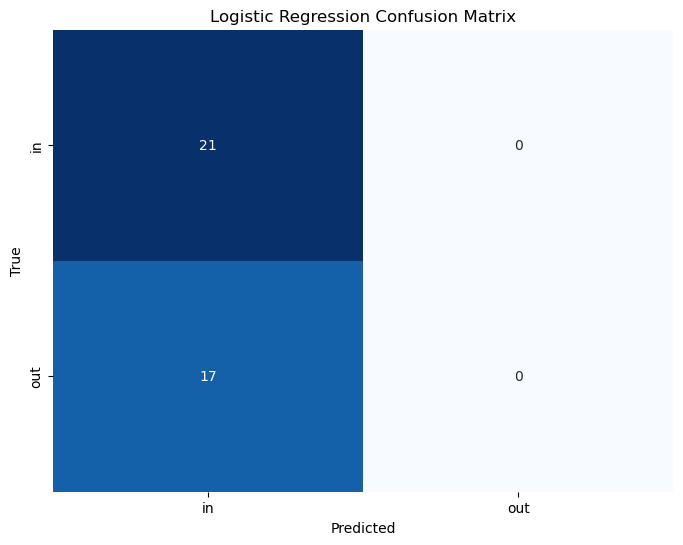

In [26]:
# logistic regression
# define the predictors and outcomes
X = np.array(df[['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg']]) # using all responses in case the slope is different for any one of them
y = np.array(pd.to_numeric(df['inOrOut']))

# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=0) # setting a larger test size since we have such a small data set, random_state: get the same answer every time

# scale the X (best to do for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# tune the model using cross-validation on the training data
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring = 'accuracy') # using the liblinear solver because it's supposedly good for small datasets
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# fit the model using the best parameters
log_reg = LogisticRegression(C = .001, penalty = 'l1', solver='liblinear') # smaller values of C specify stronger regularization, L1 Regularization = lasso regression (removes unecssary coefficients)
log_reg.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg.predict(X_test_scaled)

# print the coefficients
feature_names = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg']
coefs = log_reg.coef_[0]
coefs_w_names = list(zip(feature_names, coefs))
print('Coefficients:')
for feature, coefficient in coefs_w_names:
    print(f"{feature}: {coefficient}")

# evaluate
print('Classification report for logistic regression:')
print(classification_report(y_test, log_reg_predictions))

# confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)
# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=group_class_names, yticklabels=group_class_names)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classifying in/out-group using additional predictors
- Originally I thought I could include age, gender, priming received, and the interaction between priming received and trait-level learning/performance orientation. However, I realized that I would only want to include these as covariates in a model with empathy, altruism, or perspective taking as the outcome. Age and gender should not have an effect on which group someone was in because people were randomized. Gender and age are supposed to be somewhat evenly distributed across groups. When I fit a model including these predictors, it increased it's accuracy by picking up on that the out-group has a slight greater average age by chance. It wasn't picking up any relationship between age and the responses to questions. Something shoudl only be used as a predictor when it is expected to influence the outcome, not one of the other predictors.
- **Included the additional textual analysis predictors**, but didn't age, gender, and priming received for the reasons stated above

Best Parameters: {'C': 0.001, 'penalty': 'l1'}
pt_1: 0.0
pt_2: 0.0
pt_3: 0.0
pt_4: 0.0
pt_5: 0.0
emp: 0.0
dg: 0.0
avg_sentiment: 0.0
first_person_pronoun_count: 0.0
second_person_pronoun_count: 0.0
third_person_pronoun_count: 0.0
Classification report for logistic regression:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        21
           1       0.00      0.00      0.00        17

    accuracy                           0.55        38
   macro avg       0.28      0.50      0.36        38
weighted avg       0.31      0.55      0.39        38



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


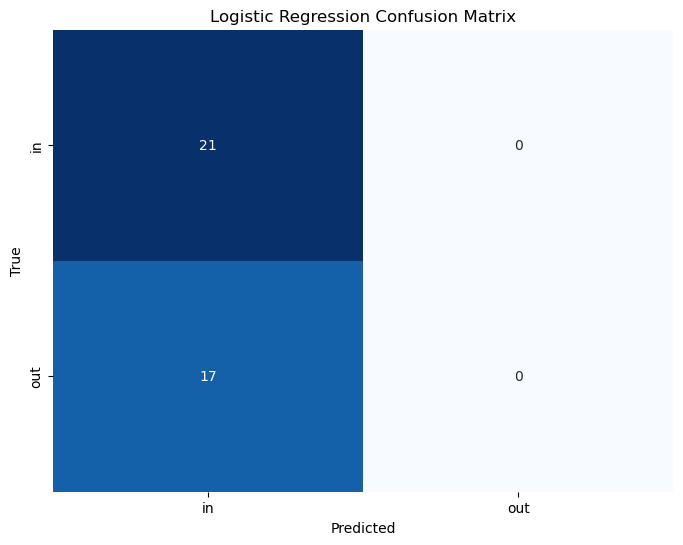

In [43]:
# logistic regression
# removing what I thought I was using as covariates, but I realized the model is just picking up on differences in the distribution of age and gender in the groups
# the covariates don't predict in/out-group but rather (potentially) have a relationship with empathy, altruism, and perspective taking
# define the predictors and outcomes
X = np.array(df[['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg', 
                'avg_sentiment', 'first_person_pronoun_count', 'second_person_pronoun_count', 'third_person_pronoun_count']]) # using all responses in case the slope is different for any one of them
y = np.array(pd.to_numeric(df['inOrOut']))

# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=0) # setting a larger test size since we have such a small data set, random_state: get the same answer every time

# scale the X (best to do for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# tune the model using cross-validation on the training data
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring = 'accuracy') # using the liblinear solver because it's supposedly good for small datasets
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# fit the model using the best parameters
log_reg = LogisticRegression(C = .001, penalty = 'l1', solver='liblinear') # smaller values of C specify stronger regularization, L1 Regularization = lasso regression (removes unecssary coefficients)
log_reg.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg.predict(X_test_scaled)

# print the coefficients
feature_names = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg', 
                'avg_sentiment', 'first_person_pronoun_count', 'second_person_pronoun_count', 'third_person_pronoun_count']
coefs = log_reg.coef_[0]
coefs_w_names = list(zip(feature_names, coefs))
for feature, coefficient in coefs_w_names:
    print(f"{feature}: {coefficient}")

# evaluate
print('Classification report for logistic regression:')
print(classification_report(y_test, log_reg_predictions))

# confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)
# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=group_class_names, yticklabels=group_class_names)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classify priming received

Best Parameters: {'C': 1, 'penalty': 'l2'}
pt_1: 0.19970522746189848
pt_2: -0.22037488578421674
pt_3: -0.42813156101715055
pt_4: 0.06365804022703213
pt_5: -0.00846141533011425
emp: 0.7070892912419351
dg: -0.20616006593244487
avg_sentiment: -0.3740426169767662
first_person_pronoun_count: -0.23047025090397408
second_person_pronoun_count: 0.14151817356063978
third_person_pronoun_count: -0.4422405920704819
Classification report for logistic regression:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65        21
           1       0.58      0.65      0.61        17

    accuracy                           0.63        38
   macro avg       0.63      0.63      0.63        38
weighted avg       0.64      0.63      0.63        38



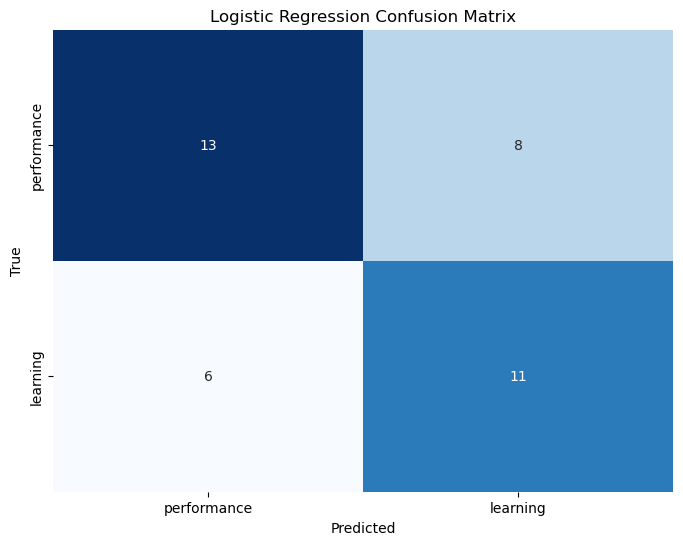

In [45]:
# logistic regression
# trying it with only the predictors we would reasonably assume are related to priming received
# trait-level performance and learning orientation technically shouldn't be associated with this
# define the predictors and outcomes
X = np.array(df[['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg',
               'avg_sentiment', 'first_person_pronoun_count', 'second_person_pronoun_count', 'third_person_pronoun_count']]) # using all responses in case the slope is different for any one of them
y = np.array(pd.to_numeric(df['priming_received']))

# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=0) # setting a larger test size since we have such a small data set, random_state: get the same answer every time

# scale the X (best to do for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# tune the model using cross-validation on the training data
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring = 'accuracy') # using the liblinear solver because it's supposedly good for small datasets
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# fit the model using the best parameters
log_reg = LogisticRegression(C = 1, penalty = 'l2', solver='liblinear', max_iter = 5000) # smaller values of C specify stronger regularization, L1 Regularization = lasso regression (removes unecssary coefficients)
log_reg.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg.predict(X_test_scaled)

# print the coefficients
feature_names = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg',
               'avg_sentiment', 'first_person_pronoun_count', 'second_person_pronoun_count', 'third_person_pronoun_count']
coefs = log_reg.coef_[0]
coefs_w_names = list(zip(feature_names, coefs))
for feature, coefficient in coefs_w_names:
    print(f"{feature}: {coefficient}")
    
# evaluate
print('Classification report for logistic regression:')
print(classification_report(y_test, log_reg_predictions))

# confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)
# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=priming_class_names, yticklabels=priming_class_names)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classifying Gender
Just went ahead and used the model with everything in it since I'm using a penalty for hte number of slopes included. Any slope that is not important

Best Parameters: {'C': 0.1, 'penalty': 'l2'}

Coefficients:
pt_1: -0.29014410554853964
pt_2: -0.1602185703951599
pt_3: -0.10433201450647707
pt_4: 0.07853123704141761
pt_5: -0.16446664063195937
emp: 0.22891137202472445
dg: -0.05802731047121679
trait_learning_avg: -0.035706336924078534
trait_performance_avg: 0.18556562389136602
avg_sentiment: 0.21935183178778928
first_person_pronoun_count: -0.06518014185308302
second_person_pronoun_count: -0.017819415577323472
third_person_pronoun_count: -0.05174502130252831

Classification report for logistic regression:
              precision    recall  f1-score   support

           0       0.54      0.39      0.45        18
           1       0.56      0.70      0.62        20

    accuracy                           0.55        38
   macro avg       0.55      0.54      0.54        38
weighted avg       0.55      0.55      0.54        38



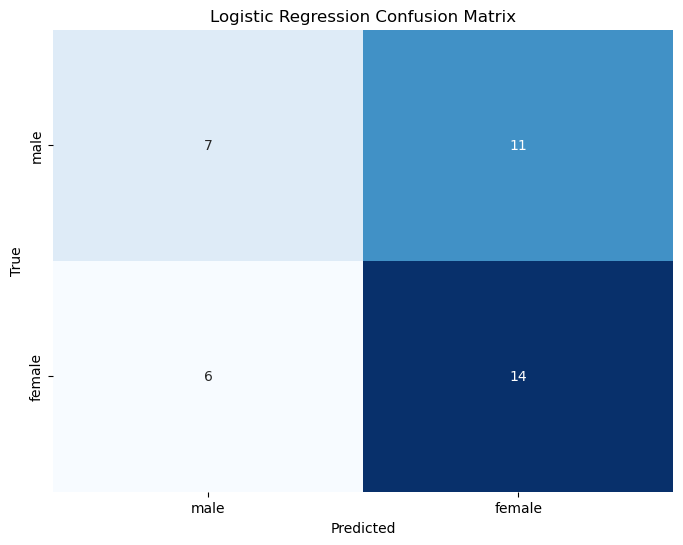

In [40]:
# logistic regression
# define the predictors and outcomes
X = np.array(df[['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg', 
                 'trait_learning_avg', 'trait_performance_avg',
                'avg_sentiment', 'first_person_pronoun_count', 'second_person_pronoun_count', 'third_person_pronoun_count']]) # using all responses in case the slope is different for any one of them
y = np.array(pd.to_numeric(df['gender']))

# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=0) # setting a larger test size since we have such a small data set, random_state: get the same answer every time

# scale the X (best to do for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# tune the model using cross-validation on the training data
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring = 'accuracy') # using the liblinear solver because it's supposedly good for small datasets
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# fit the model using the best parameters
log_reg = LogisticRegression(C = .1, penalty = 'l2', solver='liblinear') # smaller values of C specify stronger regularization, L1 Regularization = lasso regression (removes unecssary coefficients)
log_reg.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg.predict(X_test_scaled)

# print the coefficients
feature_names = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg', 
                 'trait_learning_avg', 'trait_performance_avg',
                'avg_sentiment', 'first_person_pronoun_count', 'second_person_pronoun_count', 'third_person_pronoun_count']
coefs = log_reg.coef_[0]
coefs_w_names = list(zip(feature_names, coefs))
print('\nCoefficients:')
for feature, coefficient in coefs_w_names:
    print(f"{feature}: {coefficient}")

# evaluate
print('\nClassification report for logistic regression:')
print(classification_report(y_test, log_reg_predictions))

# confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)
# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=gender_class_names, yticklabels=gender_class_names)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Predicting Empathy